## 1. Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import Tensor


from distributions.samplers import StandardNormalSampler, SwissRollSampler
from distributions.estimators import BayesianGMM
from pinn_bridge_network import TrainConfig, train
from pinn_bridge_network import simulate_sde_to_t1_twoheads, simulate_pf_ode_twoheads
from pinn_bridge_network import diagnose_drift_sampler
from display_tools.visualizations import make_density_movie

## 2. Config

In [2]:

OUTPUT_SEED = 42

BATCH_SIZE = 128

EPSILON = 0.002 # original
EPSILON = 0.1



In [3]:
#Set seed
torch.manual_seed(OUTPUT_SEED); np.random.seed(OUTPUT_SEED)



## 3. Create samplers

In [4]:
X_sampler = StandardNormalSampler(dim=2, device="cpu")
Y_sampler = SwissRollSampler(dim=2, device="cpu")

## 4 Set the Density Estimator

In [5]:
# sample some data
X0, X1 = X_sampler.sample(100*BATCH_SIZE), Y_sampler.sample(100*BATCH_SIZE)


In [6]:
# Set the density estimator.
# This wrapper class estimates the initial and final densities.
boundary_density_estimator = BayesianGMM(X0,X1)


/home/jvarela/venvs/pinnbridge/lib/python3.10/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


/home/jvarela/venvs/pinnbridge/lib/python3.10/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


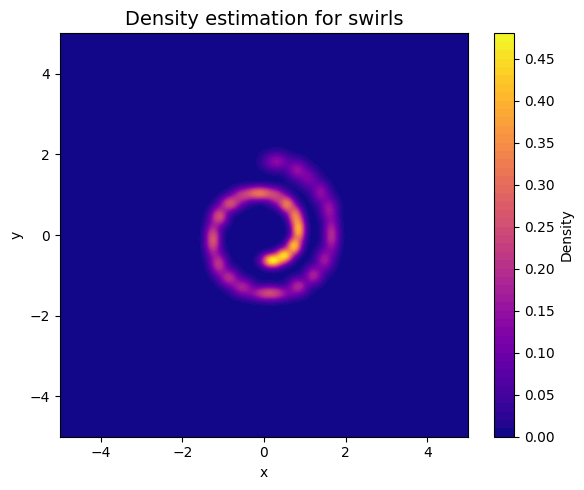

In [7]:
# Check the estimator is ok
import matplotlib.pyplot as plt

npts = 200
xline = torch.linspace(-5.0, 5.0,npts)
yline = torch.linspace(-5.0, 5.0,npts)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

with torch.no_grad():
    zgrid = boundary_density_estimator.rho1(xyinput).reshape(npts,npts)

plt.figure(figsize=(6, 5))
contour = plt.contourf(
    xgrid.cpu().numpy(),
    ygrid.cpu().numpy(),
    zgrid,
    levels=50,                # more contour levels for smoother gradient
    cmap='plasma'             # expressive colormap (try 'inferno', 'viridis', 'turbo')
)
plt.colorbar(contour, label='Density')
plt.title('Density estimation for swirls', fontsize=14)
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

## 5. Model training

In [8]:

cfg = TrainConfig()
cfg.eps = EPSILON

rho0 = boundary_density_estimator.rho0
rho1 = boundary_density_estimator.rho1

model = train(cfg,rho0,rho1,X_sampler,Y_sampler)


{'epoch': 1, 'loss': 36.32380294799805, 'loss_pde': 0.034448496997356415, 'loss_bc': 36.27680969238281, 'loss_gauge': 0.25094762444496155, 'bc_rel_0': 5.482831954956055, 'bc_rel_1': 4.590096950531006}
{'epoch': 500, 'loss': 1.1092991828918457, 'loss_pde': 0.14415693283081055, 'loss_bc': 0.7648481130599976, 'loss_gauge': 4.0058817863464355, 'bc_rel_0': 0.5979141592979431, 'bc_rel_1': 0.8345730900764465}
{'epoch': 1000, 'loss': 0.667758584022522, 'loss_pde': 0.13734310865402222, 'loss_bc': 0.32296934723854065, 'loss_gauge': 4.148922920227051, 'bc_rel_0': 0.6216816306114197, 'bc_rel_1': 0.8606760501861572}
{'epoch': 1500, 'loss': 0.4250257611274719, 'loss_pde': 0.12238059192895889, 'loss_bc': 0.1267681121826172, 'loss_gauge': 3.5175411701202393, 'bc_rel_0': 0.6097720265388489, 'bc_rel_1': 0.8734888434410095}
{'epoch': 2000, 'loss': 0.3518311381340027, 'loss_pde': 0.11094638705253601, 'loss_bc': 0.07695461064577103, 'loss_gauge': 3.2786033153533936, 'bc_rel_0': 0.5875853300094604, 'bc_rel_

In [9]:
# Check your domain, you may need to increase the domain in the config if L is smaller than the values below
torch.min(X0),torch.max(X0)


(tensor(-4.5905), tensor(4.2209))

In [10]:
X0_test, X1_test = X_sampler.sample(10*BATCH_SIZE), Y_sampler.sample(10*BATCH_SIZE)

X0_test = X0_test.to(cfg.device)
X1_test = X1_test.to(cfg.device)

X1_pred = simulate_sde_to_t1_twoheads(model,X0_test,cfg.eps)


In [11]:
# If you want drift only simulation (useful to view noiseless drift flow)
# X1_pred, traj_pf = simulate_pf_ode_twoheads(model, X0_test.to(cfg.device), cfg.eps, n_steps=4000)
# X1_pred = X1_pred.detach()
# # plot like above but with traj_pf

In [12]:
# Use this to view the relative scale of the drift and noise terms
model.eval()
stats = diagnose_drift_sampler(model, X0_test.to(cfg.device), cfg.eps, n_steps=2000, use_head="phi")
print(stats)


{'score_norm_mean': 1.863686442375183, 'score_norm_max': 4.1025919914245605, 'drift_norm_mean': 0.00018636863387655467, 'noise_norm_mean': 0.012532449327409267, 'step_norm_mean': 0.0125344917178154}


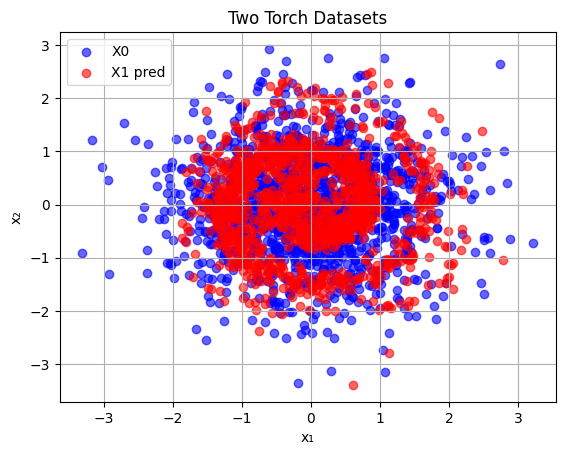

In [13]:


# Visualize the flow
X0_test_npy = X0_test.cpu().numpy()
X1_pred_npy = X1_pred.cpu().numpy()
X1_test_npy = X1_test.cpu().numpy()
# Plot
plt.scatter(X0_test_npy[:, 0], X0_test_npy[:, 1], color='blue', label='X0', alpha=0.6)
plt.scatter(X1_pred_npy[:, 0], X1_pred_npy[:, 1], color='red', label='X1 pred', alpha=0.6)
#plt.scatter(X1_test_npy[:, 0], X1_test_npy[:, 1], color='green', label='X1 test', alpha=0.6)

plt.xlabel('x₁')
plt.ylabel('x₂')
plt.title('Two Torch Datasets')
plt.legend()
plt.grid(True)
plt.show()


The drift above needs additional tuning/training to push the particles closer to the target density. It's possible reducing the uniform sampling of the PINN would lead to better flows.

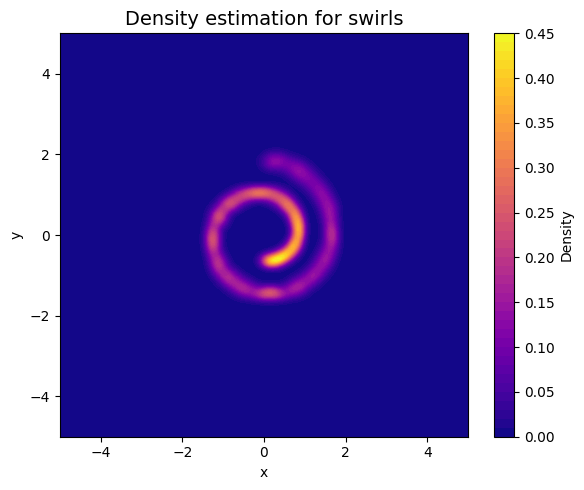

In [14]:
# Get the estimated flow field at the boundary

npts = 200
xline = torch.linspace(-5.0, 5.0, npts)
yline = torch.linspace(-5.0, 5.0, npts)
xgrid, ygrid = torch.meshgrid(xline, yline, indexing='ij')
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1).to(cfg.device)

time_1 = torch.ones(xyinput.shape[0], 1, device=cfg.device)
phi1, hphi1 = model(xyinput, time_1)
prod1 = phi1 * hphi1
zgrid = prod1.squeeze().reshape(npts, npts).detach().cpu().numpy()

plt.figure(figsize=(6, 5))
contour = plt.contourf(
    xgrid.cpu().numpy(),
    ygrid.cpu().numpy(),
    zgrid,
    levels=50,                # more contour levels for smoother gradient
    cmap='plasma'             # expressive colormap (try 'inferno', 'viridis', 'turbo')
)
plt.colorbar(contour, label='Density')
plt.title('Density estimation for swirls', fontsize=14)
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()


In [15]:
# Make a movie/gif of the marginal density

out = make_density_movie(model, cfg, npts=200, t0=0.0, t1=1.0, num_frames=120, fps=24,
                         outfile="density.gif", writer="pillow", cmap="plasma",
                         with_contours=False, clamp_min=None)
print("Saved to:", out)


Saved to: density.gif


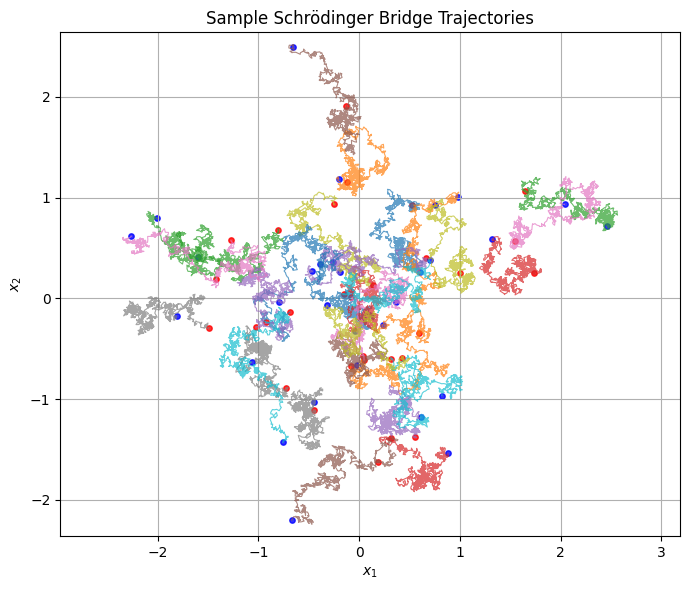

In [16]:
# Run the SDE with trajectory recording and visualize flows

X1_pred, traj = simulate_sde_to_t1_twoheads(
    model, X0_test, cfg.eps,
    return_trajectory=True,
    n_steps=1000,
    use_head="phi"
)

# traj: [n_steps+1, batch, dim]
traj_np = traj.detach().cpu().numpy()
n_steps, batch, dim = traj_np.shape

# Pick a handful of trajectories to plot
n_show = 30
idx = np.random.choice(batch, n_show, replace=False)

plt.figure(figsize=(7, 6))
for i in idx:
    path = traj_np[:, i, :]
    plt.plot(path[:, 0], path[:, 1], lw=0.8, alpha=0.7)
    plt.scatter(path[0, 0], path[0, 1], c='blue', s=15, alpha=0.8)  # start
    plt.scatter(path[-1, 0], path[-1, 1], c='red', s=15, alpha=0.8)  # end

plt.title("Sample Schrödinger Bridge Trajectories")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()
